In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import cv2
import torch
from torch.utils import data
from PIL import Image
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
txt = np.genfromtxt('russianTrafficSigns/test_labels.txt',delimiter =';', dtype= None,encoding=None)

dic ={}
for i in range (0,len(txt)):
    img_name = txt[i][0]
    target = [txt[i][1],txt[i][2],txt[i][3],txt[i][4],txt[i][5]]
    clas = txt[i][-1]
    if(img_name in dic):
        dic[img_name].append(target)
    else:
        dic[img_name] = [target]
print("Number of Images: " + str(len(dic)))

Number of Images: 5000


{3: 301, 8: 887, 71: 206, 32: 263, 26: 555, 23: 386, 13: 801, 7: 5958, 6: 400, 72: 32, 129: 30, 101: 18, 15: 249, 25: 148, 1: 2000, 20: 162, 85: 44, 40: 97, 63: 114, 9: 13, 56: 63, 4: 946, 94: 67, 82: 233, 77: 45, 109: 58, 60: 95, 33: 152, 61: 26, 55: 253, 43: 1887, 21: 20, 41: 227, 2: 507, 52: 135, 102: 53, 12: 149, 47: 247, 22: 167, 10: 233, 136: 12, 69: 198, 99: 27, 38: 67, 64: 29, 35: 200, 122: 87, 49: 121, 70: 8, 17: 284, 81: 146, 73: 2, 116: 69, 5: 206, 31: 13, 65: 24, 16: 47, 42: 25, 92: 72, 117: 64, 143: 18, 54: 142, 46: 188, 58: 32, 66: 40, 11: 8, 80: 46, 67: 16, 126: 9, 120: 54, 27: 25, 28: 34, 39: 63, 100: 18, 24: 11, 37: 15, 51: 15, 105: 1, 45: 40, 68: 146, 93: 9, 148: 9, 30: 37, 57: 37, 75: 12, 53: 11, 62: 60, 19: 15, 118: 17, 29: 41, 90: 10, 128: 28, 89: 25, 127: 12, 97: 9, 87: 57, 121: 18, 34: 8, 124: 10, 48: 21, 125: 6, 88: 22, 154: 3, 142: 7, 119: 7, 86: 65, 14: 61, 112: 8, 131: 27, 110: 24, 145: 8, 95: 16, 103: 9, 78: 10, 44: 21, 50: 45, 140: 4, 130: 16, 115: 23, 83: 

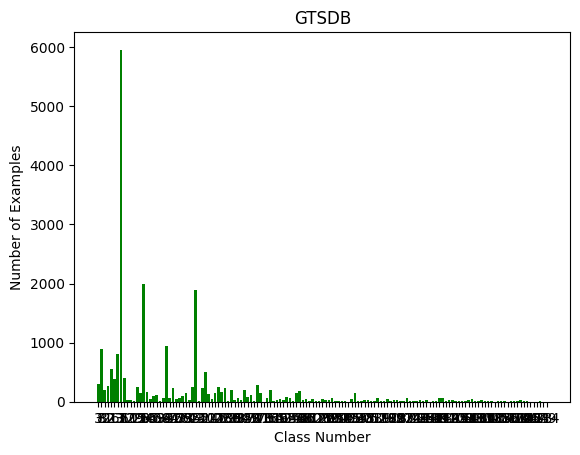

In [3]:
#Data Distribution

cls_lst = {}

for i in dic:
    for j in dic[i][:]:
        #print(len(dic[i]))
        for k in range(len(dic[i])):
            clss = dic[i][:][k][-1]
            if clss in cls_lst:
                cls_lst[clss] += 1
            else:
                cls_lst[clss] = 1
                
print(cls_lst)

xx = []
yy = []
for i in cls_lst:
    xx.append(str(i))
    yy.append(cls_lst[i])

x_pos = [i for i, _ in enumerate(xx)]

plt.bar(x_pos, yy, color='green')
plt.xlabel("Class Number")
plt.ylabel("Number of Examples")
plt.title("GTSDB")
plt.xticks(x_pos, xx)

plt.show()

In [4]:
# #Copy only files that are annotated in the gt.txt to imagesf
# import shutil
# 
# pt = glob('/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns/images/*.jpg')
# 
# len(pt)
# for i in range(len(dic)):
#     ofile = r'/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns/images/{}'.format(list(dic)[i])
#     target = r'/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns/imagesf_test/{}'.format(list(dic)[i])
#     shutil.copyfile(ofile, target)
# 
# print(len(glob('/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns/imagesf_test/*.jpg')))
# len(dic)

In [5]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imagesf_test"))))
 
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "imagesf_test", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")        
        objects = dic[self.imgs[idx]]
        boxes = []
        labels = []
        for obj in objects:
            name = obj[-1]
            labels.append(np.int(name))
            xmin = np.float(obj[0])
            ymin = np.float(obj[1])
            xmax = np.float(obj[2])
            ymax = np.float(obj[3])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [6]:
import utilss
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
 
    return T.Compose(transforms)

In [7]:
from engine import train_one_epoch, evaluate
import utilss
import torch.nn as nn
os.environ['TORCH_HOME'] = '/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/'
root = r'/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/russianTrafficSigns'

num_classes = 156
dataset_test = myDataset(root, get_transform(train=False))
indices = torch.randperm(len(dataset_test)).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, # num_workers=4,
    collate_fn=utilss.collate_fn)

model = torch.load(r'/home/vorkov/Workspace/Python/TrafficSignDetection/experiments/train2ep_lr0.0005_mom0.9.pkl')
device = torch.device('cuda')
model.to(device)

print("Model loaded")

Model loaded


In [8]:
from engine import evaluate

_, metric_logger = evaluate(model, data_loader_test, device=device)

creating index...
index created!
Test:  [ 0/25]  eta: 0:00:21  model_time: 0.8088 (0.8088)  evaluator_time: 0.0052 (0.0052)  time: 0.8726  data: 0.0443  max mem: 2086
Test:  [24/25]  eta: 0:00:00  model_time: 0.2671 (0.2894)  evaluator_time: 0.0049 (0.0054)  time: 0.3158  data: 0.0376  max mem: 2121
Test: Total time: 0:00:08 (0.3394 s / it)
Averaged stats: model_time: 0.2671 (0.2894)  evaluator_time: 0.0049 (0.0054)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.794
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.501
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.713
 Average Recall     (AR) @[ IoU=